In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

pd.options.display.max_rows = 47276
pd.options.display.max_columns = 20000

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from fbprophet import Prophet


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler

In [2]:
root = os.path.join(os.getcwd(), 'DATA')

In [3]:
df_raw = pd.read_excel(os.path.join(root, 'train.xlsx'))
cpi = pd.read_csv(os.path.join(root, 'preprocessed_cpi.csv'))
oil = pd.read_csv(os.path.join(root, 'preprocessed_oil.csv'))
weather = pd.read_csv(os.path.join(root, 'preprocessed_weather.csv'))
kor_weather = pd.read_csv(os.path.join(root, 'preprocessed_weather_korea.csv'))
exchange = pd.read_csv(os.path.join(root, 'preprocessed_exchange.csv'))

In [4]:
from datetime import date, timedelta


def set_week(df, date):
    '''
    df : datetime 형식의 컬럼을 가지고 있는 dataframe
    date : df에서 datetime 형식을 가진 컬럼명
    return : date의 연도 컬럼과 주차 컬럼을 추가한 dataframe
    '''
    df[date] = pd.to_datetime(df[date])
    df[date] = df[date].dt.date
    df['year'] = df.apply(func=lambda x: x[date].isocalendar()[0], axis=1)
    df['week'] = df.apply(func=lambda x: x[date].isocalendar()[1], axis=1)

################################################################################################################################################################

def fillna(data, all_nation, major_nation , method=None):
  
  '''

  주요 수출구 결측치 제거 함수
  all_nation = 모든 수출국
  major_nation = 주요 수출국 ['칠레', '중국', '노르웨이', '페루', '태국', '베트남']
  method = ffill, bfill

  '''

  for nation in all_nation:
    for m_nation in major_nation:
      if nation == m_nation:

        if method == 'ffill':
          data[data['CTRY_2'] == m_nation].fillna(method='ffill', inplace=True)

        elif method == 'bfill':
          data[data['CTRY_2'] == m_nation].fillna(method='ffill', inplace=True)

################################################################################################################################################################

def na_list(data):

  '''
  결측치 컬럼 확인
  '''
  lst = []
  for col in data.columns:
    if data[col].isna().sum() > 0 :
      lst.append(col)
    else: pass

  return lst

################################################################################################################################################################

def drop_col(data):
  '''
  결측치 컬럼 제거
  '''
  lst = na_list(data)
  data.drop(lst, axis=1,inplace=True)

################################################################################################################################################################

# def scaler_col(data, col, method):
#   '''
#   전처리 함수
#   data 
#   col : ['cpi_total', 'cpi_fish', 'oil', 'wind_kr', 'temperature_kr','water_temp_kr']
#   method : standard, minmax, robust, log
#   '''
#   if method == 'standard':
#     scaler = StandardScaler()
#     data[col] = scaler.fit_transform(data[col])

#   elif method == 'minmax':
#     scaler = StandardScaler()
#     data[col] = scaler.fit_transform(data[col])

#   elif method == 'robust':
#     scaler = StandardScaler()
#     data[col] = scaler.fit_transform(data[col])

#   elif method == 'log':
#     data[col] = np.log1p(data[col])

#   elif method == 'none':
#     pass

################################################################################################################################################################

# def make_quarter(data, col):
#   '''
#   분기 행 추가
#   col : 'REG_DATE'
#   '''
#   data[col] = pd.to_datetime(data[col])
#   data['Quarter'] = data[col].dt.quarter
#   data['Quarter_ver2'] = data['Quarter'] + (data['year'] - data['year'].min()) * 4
#   dummies = pd.get_dummies(df_train['Quarter'], prefix='Quater_Dummy', drop_first=True)

#   if 'Quarter' in data.columns:
#     data = pd.concat([data, dummies], axis=1)
#     del data['Quarter']

################################################################################################################################################################
################################################################################################################################################################

# def nation_week_df(data,days, nation, kind):
#   '''
  
#   국가 종류별 주차별 가격 평균 df  및 결측값 채움.
#   data = df
#   days = set(df_copy['REG_DATE'])
#   nation = 국가이름
#   kind = 종류이름
  
#   '''
#   kind_lst = []
#   price_lst = []
#   temp_df = pd.DataFrame()

#   for day in days:
#     nation_kind = data[(data['CTRY_2'] == nation) & (data['REG_DATE'] == day) & (data['P_NAME'] == kind)]
#     kind_lst.append(nation_kind)
#   kind_df = pd.concat(kind_lst, axis=0).sort_values(by='REG_DATE').reset_index(drop=True)

#   for day in days:
#     price_lst.append(kind_df[ (kind_df['REG_DATE'] == day) ]['P_PRICE'].mean())

#   temp_df = temp_df.append(price_lst)
#   temp_df = temp_df.dropna().reset_index(drop=True)
#   temp = list(temp_df.iloc[:,0])
#   kind_df = kind_df.drop_duplicates('REG_DATE').reset_index(drop=True)
  
#   kind_df['P_PRICE'] = temp
#   kind_df.set_index('REG_DATE', inplace=True)
#   kind_df = kind_df.asfreq('W-mon')

#   kind_df.fillna(method = 'ffill', inplace= True)

#   return kind_df

################################################################################################################################################################

# def last_result(data, days ,nation, kind, dummy_list):
  
#   '''
#   dummy_list = ['CTRY_1','CTRY_2','P_PURPOSE','CATEGORY_1','CATEGORY_2','P_NAME']

#   '''

#   df = nation_week_df(data, days, nation, kind)
#   import_type_list = set()

#   for tmp in df['P_IMPORT_TYPE'].unique():
#     for i in tmp.split(','):
#       import_type_list.add(i)

#   for name in import_type_list:
#     df[name] = 0
#     df.loc[df['P_IMPORT_TYPE'].str.contains(name, regex=False), name] = 1

#   result = pd.get_dummies(data = df, columns = dummy_list)

#   result.drop("P_IMPORT_TYPE", axis=1, inplace=True)

#   return result

In [5]:
set_week(df_raw, 'REG_DATE')

In [6]:
df_train = pd.merge(df_raw, cpi, how='left', on=['year','week'])
df_train = pd.merge(df_train, oil, how='left', on=['year','week'])
df_train = pd.merge(df_train, weather, how='left', on=['year','week', 'CTRY_1'])
df_train = pd.merge(df_train, kor_weather, how='left', on=['year','week'])
df_train = pd.merge(df_train, exchange, how='left', on=['year','week','CTRY_2'])
df_train.drop('P_TYPE', axis=1, inplace=True)

In [7]:
set_week(df_train, 'REG_DATE')

In [8]:

def group_kind(data, kind):
  df = data[['REG_DATE','P_NAME','P_PRICE']]
  df = df[df['P_NAME'] == kind]
  df = df.groupby(['REG_DATE','P_NAME'], as_index=False).mean()
  df = df.set_index('REG_DATE')
  df = df.asfreq('W-mon')
  df = df.fillna(method='ffill')

  return df

def re_index(df, kind):
  df = group_kind(df, kind)
  df = df.reset_index()

  return df

def prophet_forecast(df,kind):
  df = re_index(df, kind)
  df = df[['REG_DATE','P_PRICE']].reset_index(drop=True)
  df = df.rename(columns = {'REG_DATE':'ds', 'P_PRICE':'y'})
  df.plot(x='ds', y='y', figsize=(9, 3))

  model = Prophet()
  model.fit(df)   

  future = model.make_future_dataframe(periods=100, freq='W') #  가격 예측
  forecast = model.predict(future)
  hat = forecast['yhat']

  df['pred'] = hat
  df['pred - real'] = df['pred'] - df['y']


  fig1 = model.plot(forecast) # 검은 점: 실제 가격, 파란 선 :추세
  fig2 = model.plot_components(forecast) # 경향 및 일년동안의 가격 변화

  return df

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,y,pred,pred - real
0,2015-12-28,9.922919,9.511177,-0.411742
1,2016-01-04,9.279109,9.572202,0.293093
2,2016-01-11,10.658746,9.668782,-0.989964
3,2016-01-18,9.308712,9.625962,0.317251
4,2016-01-25,9.399535,9.454687,0.055152
5,2016-02-01,8.748914,9.324736,0.575822
6,2016-02-08,8.533956,9.365070,0.831114
7,2016-02-15,9.927874,9.537296,-0.390579
8,2016-02-22,9.576744,9.711766,0.135022
9,2016-02-29,11.494779,9.820322,-1.674457


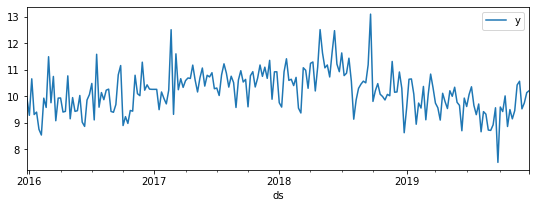

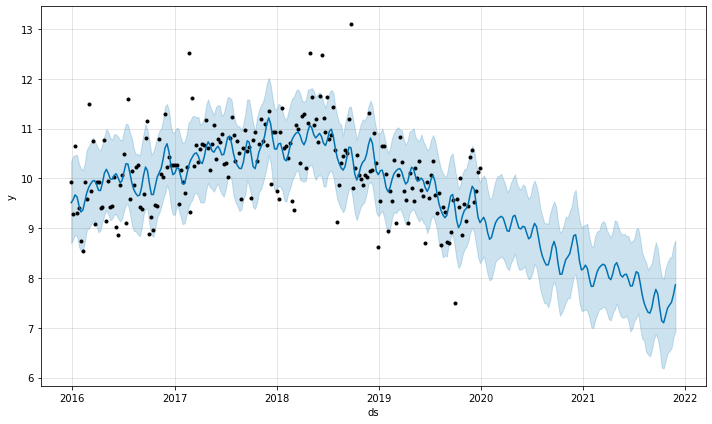

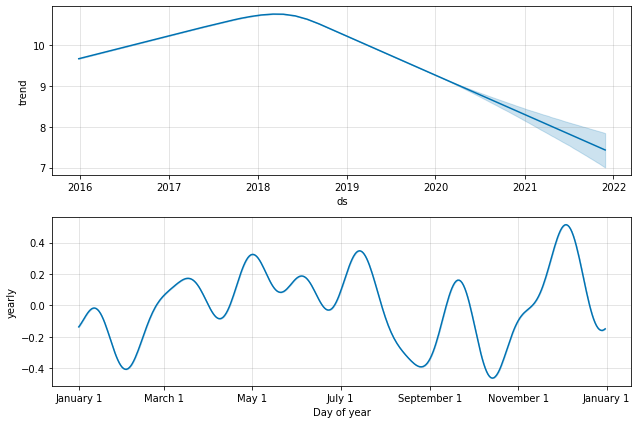

In [9]:
prophet_forecast(df_train,'흰다리새우')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,y,pred,pred - real
0,2015-12-28,1.741647,1.983392,0.241745
1,2016-01-04,1.787152,1.961125,0.173972
2,2016-01-11,1.345855,1.961161,0.615305
3,2016-01-18,1.675178,1.984086,0.308908
4,2016-01-25,2.185579,2.022721,-0.162858
5,2016-02-01,2.876396,2.066614,-0.809782
6,2016-02-08,2.876396,2.097562,-0.778834
7,2016-02-15,2.103069,2.100344,-0.002725
8,2016-02-22,1.902785,2.082519,0.179733
9,2016-02-29,2.426714,2.071375,-0.355339


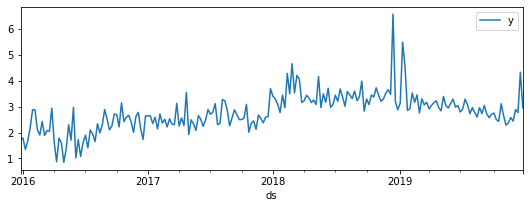

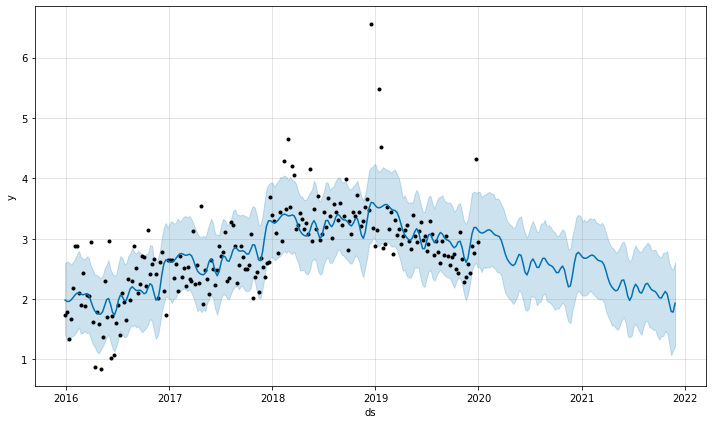

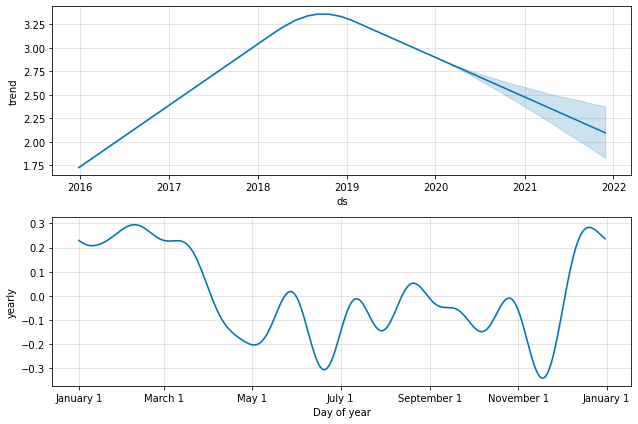

In [10]:
prophet_forecast(df_train,'오징어')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,y,pred,pred - real
0,2015-12-28,13.287212,12.834148,-0.453065
1,2016-01-04,12.331994,12.705827,0.373833
2,2016-01-11,12.876513,12.800139,-0.076373
3,2016-01-18,13.387350,12.952128,-0.435222
4,2016-01-25,12.644323,12.892315,0.247992
5,2016-02-01,11.185117,12.595879,1.410762
6,2016-02-08,12.859437,12.314450,-0.544987
7,2016-02-15,13.171931,12.275514,-0.896416
8,2016-02-22,12.669716,12.439377,-0.230339
9,2016-02-29,12.835547,12.607540,-0.228008


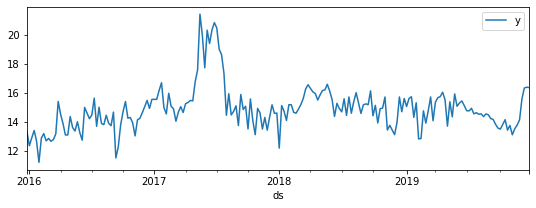

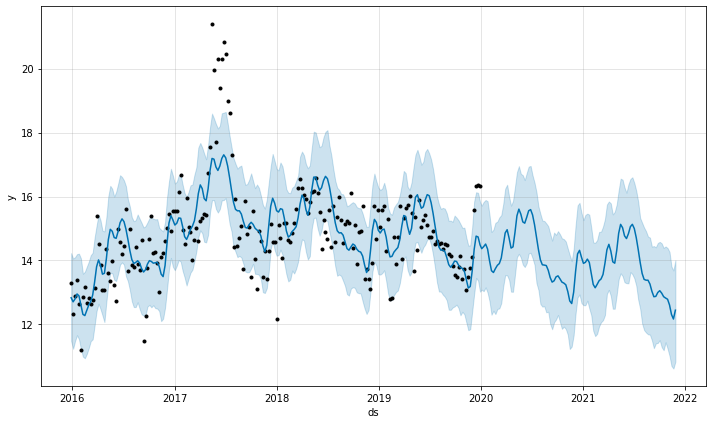

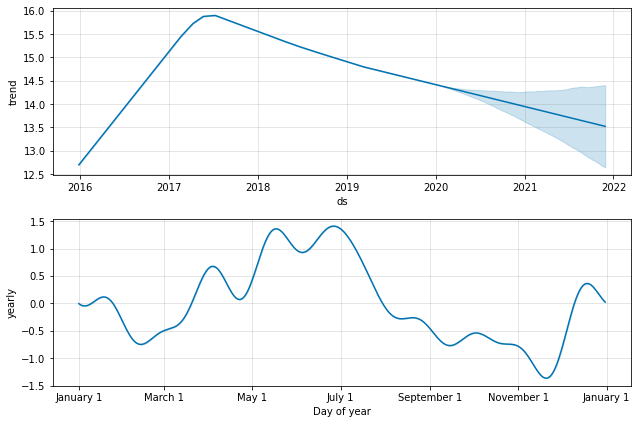

In [11]:
prophet_forecast(df_train,'연어')

## Sample

In [12]:
sh = re_index(df_train, '오징어').drop('P_NAME', axis=1)

In [13]:
sh = sh.set_index('REG_DATE')

In [14]:
sh.index = pd.to_datetime(sh.index)
sh = sh.asfreq('W-mon')
sh = sh.fillna('ffill')

In [15]:
### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    RMSE = np.sqrt(((Y_real.values.flatten() - Y_pred)**2).mean())
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, RMSE, MAPE], index=['MAE', 'RMSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(y_train, pred_tr_reg1, y_test, pred_te_reg1, graph_on=True)


## RNN

Train_size: (114, 1) Test_size: (96, 1)
X_train: (109, 5, 1) Y_train: (109, 1)
X_test: (91, 5, 1) Y_test: (91, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 5, 128)            16640     
_________________________________________________________________
dropout (Dropout)            (None, 5, 128)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 5, 256)            98560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 5, 128)            49280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 128)            0         
________

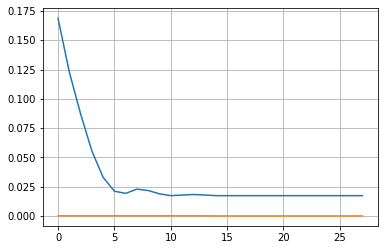

3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00


,MAE,RMSE,MAPE
Train,0.369997,0.500223,16.732884
Test,0.301962,0.536006,8.428897


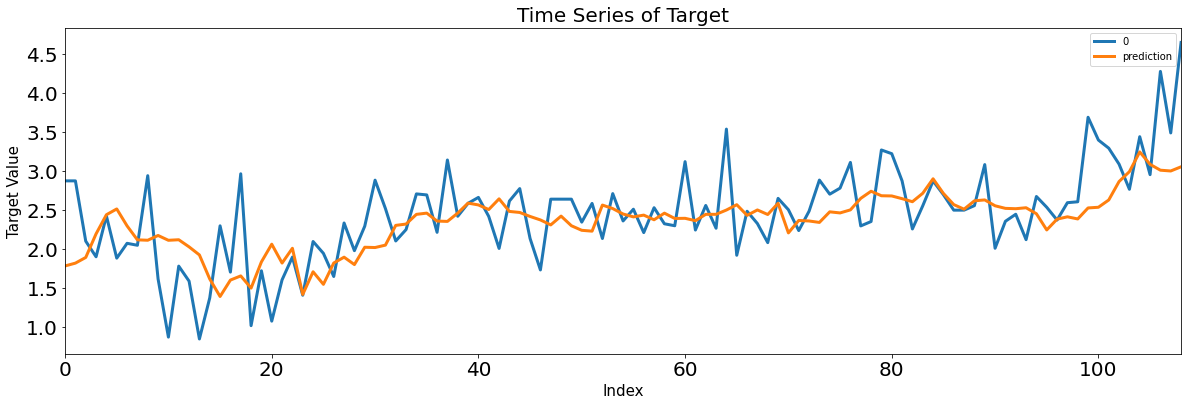

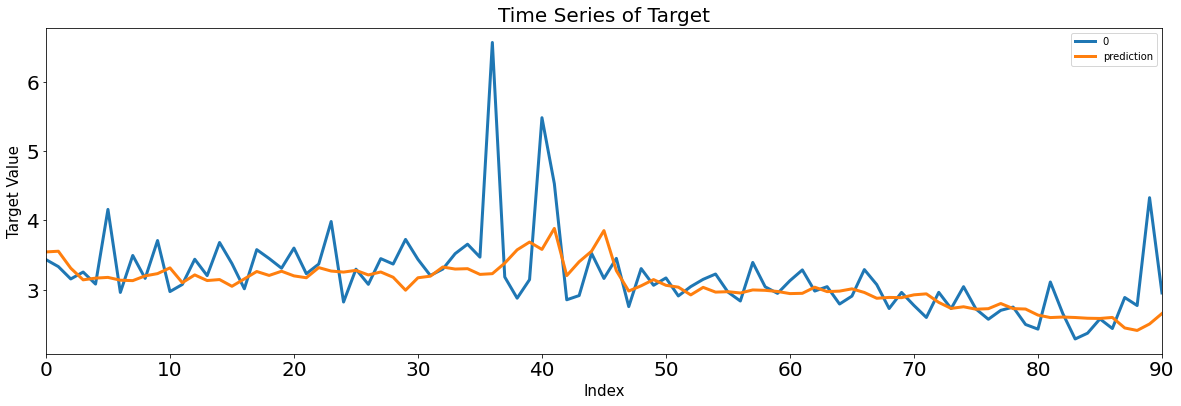

In [16]:
raw_all = sh.copy()
# Parameters
criteria = '2018-03-01'
scaler = preprocessing.MinMaxScaler()
sequence = 5
batch_size = 32
epoch = 30
verbose = 1
dropout_ratio = 0


# Feature Engineering
## Train & Test Split
train = raw_all.loc[raw_all.index < criteria,:]
test = raw_all.loc[raw_all.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# Callback
ely = EarlyStopping(monitor='loss', patience=5, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', factor=0.001, patience=3)

# RNN
model = Sequential()
model.add(SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(SimpleRNN(64, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer=Adam(0.0001), loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch, callbacks=[ely, rlp],
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_RNN, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_RNN)

## LSTM

Train_size: (114, 1) Test_size: (96, 1)
X_train: (109, 5, 1) Y_train: (109, 1)
X_test: (91, 5, 1) Y_test: (91, 1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 128)            66560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 256)            394240    
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 128)            197120    
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)               

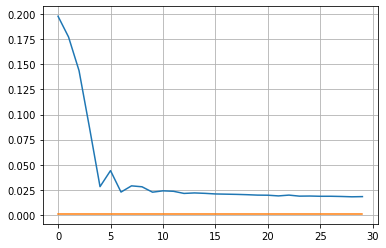

3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00


,MAE,RMSE,MAPE
Train,0.381581,0.509112,17.80766
Test,0.307666,0.540082,8.56460


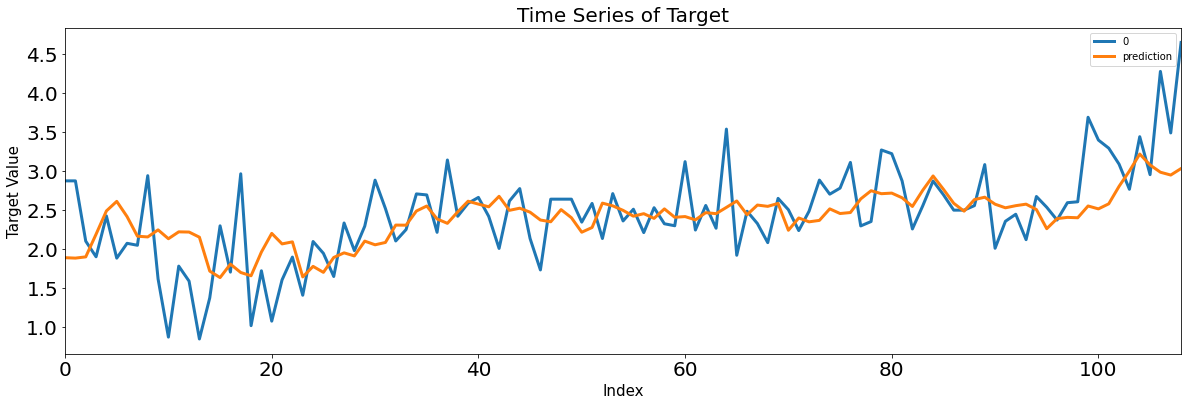

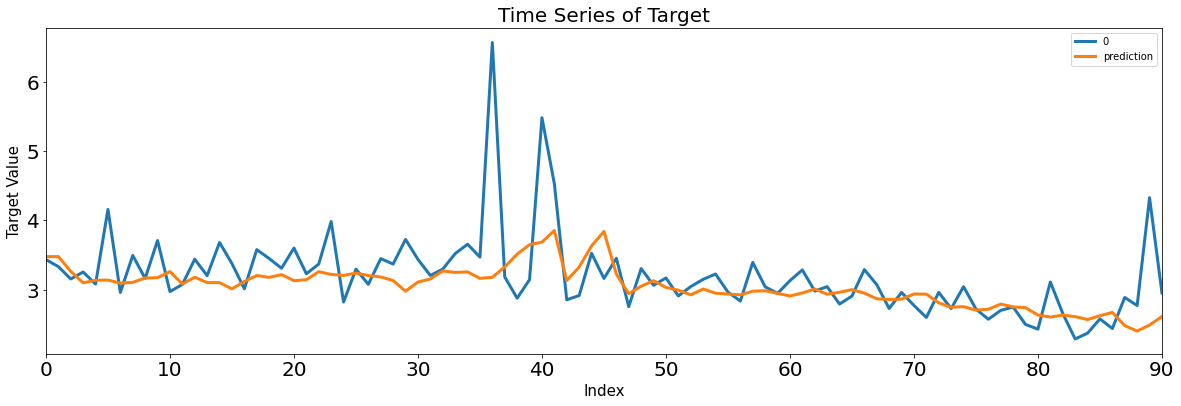

In [17]:
raw_all = sh.copy()
# Parameters
criteria = '2018-03-01'
scaler = preprocessing.MinMaxScaler()
sequence = 5
batch_size = 32
epoch = 30
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = raw_all.loc[raw_all.index < criteria,:]
test = raw_all.loc[raw_all.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# Callback
ely = EarlyStopping(monitor='loss', patience=5, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', factor=0.001, patience=3)

# LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose, callbacks=[ely, rlp])

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_LSTM)

# error analysis
# error_analysis(Residual_te, ['Error'], pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])), graph_on=True)

## GRU

Train_size: (114, 1) Test_size: (96, 1)
X_train: (109, 5, 1) Y_train: (109, 1)
X_test: (91, 5, 1) Y_test: (91, 1)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5, 128)            50304     
_________________________________________________________________
dropout_8 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 5, 256)            296448    
_________________________________________________________________
dropout_9 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 5, 128)            148224    
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 128)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 64)               

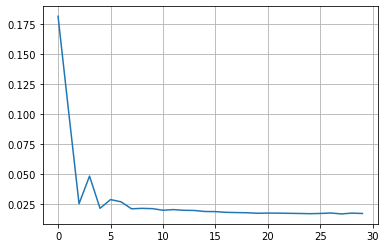

3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00


,MAE,RMSE,MAPE
Train,0.371689,0.490857,17.449438
Test,0.311604,0.527366,8.943194


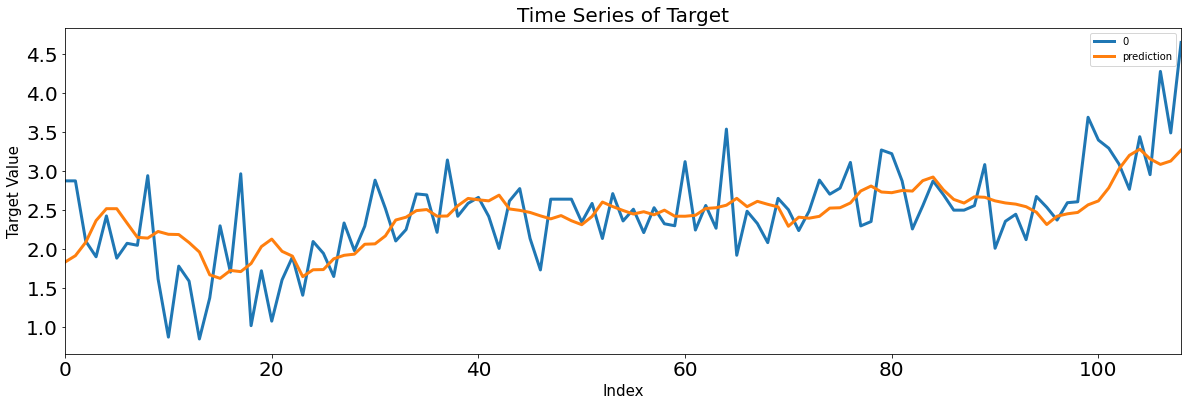

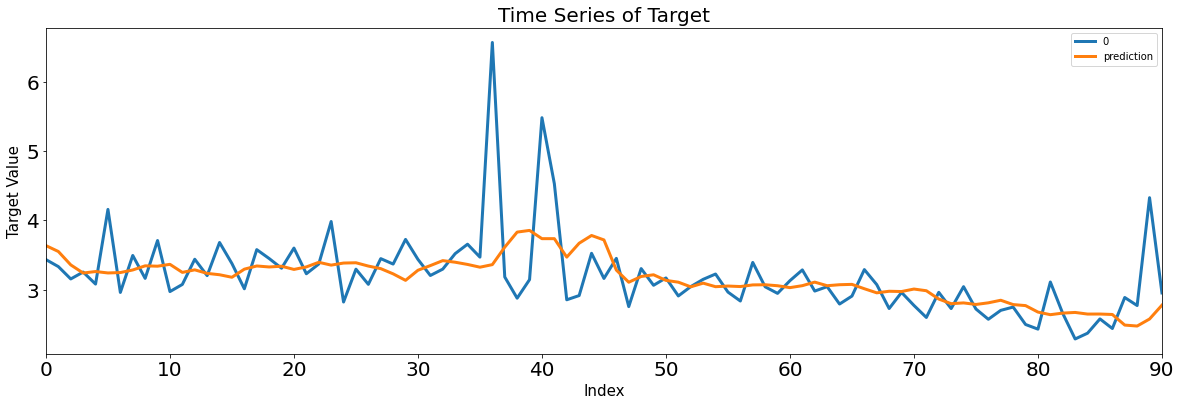

In [18]:
raw_all = sh.copy()
# Parameters
criteria = '2018-03-01'
scaler = preprocessing.MinMaxScaler()
sequence = 5
batch_size = 32
epoch = 30
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Train & Test Split
train = raw_all.loc[raw_all.index < criteria,:]
test = raw_all.loc[raw_all.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)

## Scaling
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(train_scaled) - sequence):
    X_train.append(train_scaled[index: index + sequence])
    Y_train.append(train_scaled[index + sequence])
X_test, Y_test = [], []
for index in range(len(test_scaled) - sequence):
    X_test.append(test_scaled[index: index + sequence])
    Y_test.append(test_scaled[index + sequence])

## Retype and Reshape
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler != []:
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)

# error analysis
#error_analysis(Residual_te, ['Error'], pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1])), graph_on=True)